In [2]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)


2023-08-29 00:24:03.515873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pandas as pd
import numpy as np

b = 15
f = 4
value_num = b + f

# Reading Data
df = pd.read_csv('df_KO_.csv', parse_dates=True, index_col=0)

# Select 'Close' column
df = df['Close']

df = df.last('10Y')

# Window Batching
batches = [df[i:value_num+i] for i in range(len(df) - value_num)]
np.random.shuffle(batches)

# Data Processing
processed_batches = []
for batch in batches:
    full_seq = batch.pct_change().dropna()
    df_future = full_seq[-f:]
    df_past = full_seq[:b]

    min_max = max(abs(np.min(df_past)), abs(np.max(df_past)))
    df_past = np.interp(df_past, (-min_max, min_max), (-1, 1))
    df_future = np.interp(df_future, (-min_max, min_max), (-1, 1))
    processed_batches.append([df_past, df_future])

# Train-Test Split
train_dataset = processed_batches[0: int(0.8 * len(processed_batches))]
test_dataset = processed_batches[int(0.8 * len(processed_batches)):]

# Final Dataset
dataset = [[train_dataset], [test_dataset]]

dataset = np.array(dataset)

np.save('./dataset2', dataset)


/tmp/ipykernel_41428/799053280.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)


In [4]:
dataset

array([[list([[array([-0.23749735,  0.16195881, -0.19951459,  0.34219025, -0.06455037,
                0.1554904 ,  0.04709468, -0.04269809, -0.42374728,  1.        ,
                0.07469925, -0.18595812,  0.23388828,  0.02473101, -0.00823209]), array([-0.00823209, -0.22648302,  0.08343096, -0.10379778])], [array([-0.13814899, -0.21313689, -0.40672476,  0.09713669,  0.2154286 ,
               -0.12869218, -1.        ,  0.29637138,  0.1091054 , -0.2286148 ,
                0.4265617 ,  0.3361377 ,  0.02153895, -0.03229217, -0.08617473]), array([-0.08617473,  0.49636529,  0.24569379,  0.01063133])], [array([-0.21797073,  0.14468652, -0.42209548,  0.01510398,  0.56866123,
               -0.09388272,  0.09912529,  0.08892626, -1.        ,  0.16292729,
               -0.63815088,  0.00517298,  0.23269586, -0.04619007, -0.25699662]), array([-0.25699662, -0.07256643, -0.34289918, -0.38353873])], [array([ 0.        ,  0.06174473,  0.185085  , -0.16416857,  0.28783913,
                0.1844

In [5]:
dataset = dataset[1]

In [6]:
dataset[0][1][0]

array([ 0.34807019,  0.14655373, -0.10303943, -0.50802998, -0.034923  ,
       -0.07864932, -0.28023697,  0.27355291,  0.27154195, -1.        ,
       -0.56304552, -0.70787372,  0.75869085,  0.55304889, -0.68783035])

In [7]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit as conditional labels
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dataset[0][1][1]))]

init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

init_gen_weights

<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[-0.73299704, -0.69091975, -2.10719143],
        [ 3.08691181, -0.875375  ,  3.07820736],
        [-0.47660851,  2.98291738, -0.35843882],
        [-2.45301071,  2.6492799 ,  2.04931071],
        [-2.84830758,  2.96301817, -0.81305414],
        [-2.55384995,  1.21202603, -0.40098615],
        [ 2.51167105, -2.34947083, -2.69363214],
        [-2.83623027,  0.86711347,  1.9750424 ],
        [ 0.35837442, -2.51198814,  1.36340805],
        [-0.84814107,  1.50738374, -2.17217137],
        [ 0.06943294,  0.25269529, -2.89281041],
        [ 0.81758402, -2.42052239, -0.6152866 ],
        [ 1.49246113, -2.76276544, -1.9004917 ],
        [-2.76611882,  2.52316809,  0.41278371],
        [ 0.72279436,  2.07283122, -2.71874071]],

       [[ 1.67274137,  2.72244783, -1.58553354],
        [ 1.68818842,  2.34659691, -2.22309338],
        [ 0.35784852, -1.54071889,  0.02062513],
        [-3.04203924, -0.19764728,  1.29674849],
  

In [8]:
# Testing generator circuit QNode
gen_circuit(dataset[0][1][0], init_gen_weights)

[<tf.Tensor: shape=(), dtype=float64, numpy=0.01922401711936228>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.0029118586584179207>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.005087603490551873>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.024344990206783657>]

In [9]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 19]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

discriminator = make_discrim()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             272       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16)             0         
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 dense (Dense)               (None, 1, 128)            2176      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              1

In [10]:


cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [11]:

def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc

In [12]:
gloss = []
dloss = []
acc_results = []
epoch_acc_results = []

In [13]:
EPOCHS = 1500
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w


In [14]:
new_gen_w = train(dataset[0], EPOCHS, start_epoch=1)

Step 0 in 10 epoch: Gen loss: 0.759709894657135 
         Disc loss: 1.2893078327178955 
             Accuracy: 0.5908908843994141
Step 0 in 20 epoch: Gen loss: 0.822472333908081 
         Disc loss: 1.1790895462036133 
             Accuracy: 0.5923434495925903
Step 0 in 30 epoch: Gen loss: 0.9291026592254639 
         Disc loss: 1.0346710681915283 
             Accuracy: 0.5954042971134186
Step 0 in 40 epoch: Gen loss: 1.0673675537109375 
         Disc loss: 0.8580772280693054 
             Accuracy: 0.5992256104946136
Step 0 in 50 epoch: Gen loss: 1.2772175073623657 
         Disc loss: 0.6476585268974304 
             Accuracy: 0.6036214232444763
Step 0 in 60 epoch: Gen loss: 1.6199918985366821 
         Disc loss: 0.4361615478992462 
             Accuracy: 0.6087335348129272
Step 0 in 70 epoch: Gen loss: 2.068406105041504 
         Disc loss: 0.26563405990600586 
             Accuracy: 0.6147837936878204
Step 0 in 80 epoch: Gen loss: 2.574506998062134 
         Disc loss: 0.1537651

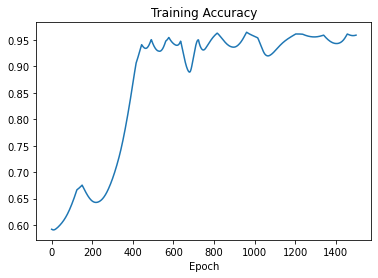

In [15]:


plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()



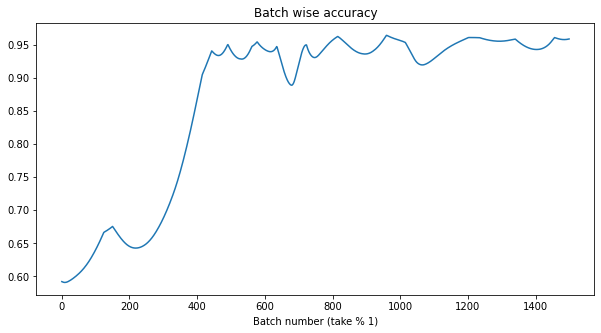

In [16]:


plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()



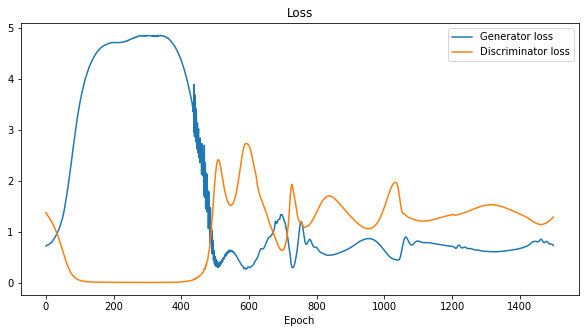

In [17]:


plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()



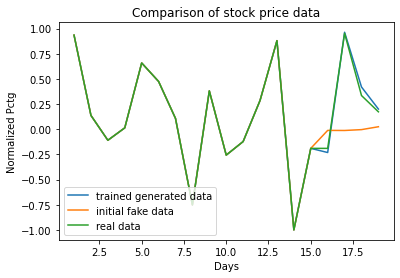

In [18]:
for i in range(batch_size):
    days =  np.arange(1, len(dataset[0][0][0]) + len(dataset[0][0][1]) + 1)
    real_stats = np.append(dataset[0][i][0], dataset[0][i][1])
    fake_stats = tf.concat([dataset[0][i][0], gen_circuit(dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dataset[0][i][0], gen_circuit(dataset[0][i][0], init_gen_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("Comparison of stock price data")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg")
    plt.legend()
    plt.show()